

# Human Eye 
This notebook is to achieve the image caption task



## Prepare MS-COCO dataset


In [1]:
import os
import tensorflow as tf

In [ ]:
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip',
                                          extract = True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2017.json'
  os.remove(annotation_zip)

In [ ]:
image_folder = '/train2017/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2017.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2017.zip',
                                      extract = True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

In [ ]:
!ls  

## Limit the train dataset
In order to validate the correctness of the code, here we use small sub-dataset to train the model.

The whole job will be trained on Google AI Platform 

In [ ]:
import random
import json
import collections
from PIL import Image

In [ ]:
with open(annotation_file, 'r') as f:
  annotations = json.load(f)

image_path_to_caption = collections.defaultdict(list)

In [ ]:
for ann in annotations['annotations']:
  caption = f"<start> {ann['caption']} <end>"
  img_path = PATH + '%012d.jpg' % (ann['image_id'])
  image_path_to_caption[img_path].append(caption)

In [ ]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

train_image_paths = image_paths[:6000]

# 6000 images -> 30000 captions

In [ ]:
train_captions = []
# this vector will store the img_path many times because one image has multiple captions 
img_path_vector = []

# The above vectors has the same length

for p in train_image_paths:
  captions = image_path_to_caption[p]
  train_captions.extend(captions)
  img_path_vector.extend([p] * len(captions))

In [ ]:
print(train_captions[0])
Image.open(img_path_vector[0])

## Preprocess
In this part, we will preprocess images and corresponding captions

### Captions Preprocess
1. tokenize captions
2. build vocabulary (bi-mapping)
3. add `<pad>` to vocabulary
4. pad the caption seqence to the length of longest caption

In [ ]:
# hyper-parameters YAML
vocab_size = 5000 + 1

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size-1, 
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

In [ ]:
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [ ]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [ ]:
# padding
caption_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [ ]:
max_length = max(len(seq) for seq in train_seqs)

### Image Preprocess
Inception_v3 expects the image size = (299, 299) with normalization in the range of (-1, 1)

In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

## Load the pretrained Image Model
This part we load Inception-v3 serving as the features extractor

In [ ]:
import numpy as np

In [ ]:
inception_v3 = tf.keras.applications.InceptionV3(include_top=False)

In [ ]:
# change the model
new_input = inception_v3.input
hidden_layer = inception_v3.layers[-1].output

model = tf.keras.Model(new_input, hidden_layer)

The shape of output of the last layer of Inception-v3 is (8,8,2048)

We flatten it to (64, 2048)

In [ ]:
all_images = sorted(set(img_path_vector))
image_data = tf.data.Dataset.from_tensor_slices(all_images)
image_data = image_data.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

In [ ]:
for imgs, paths in image_data: 
  features = model(imgs)
  features = tf.reshape(features, (features.shape[0], -1, features.shape[3]))

  for feature, path in zip(features, paths):
    p = path.numpy().decode('utf-8')
    np.save(p, feature.numpy())

## Build Dataset

In [ ]:
# hyper-parameters YAML
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
num_steps = len(img_path_vector) // BATCH_SIZE

In [ ]:
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_path_vector, caption_vector))

# Use map to load the numpy files in parallel
# refer to keras tutorial 
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle & Batch & Prefetch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## Model 
Encoder-Decoder

In [ ]:
class CNN_Encoder(tf.keras.Model):
  def __init__(self, embedding_dim):
    super(CNN_Encoder, self).__init__()
    self.fc = tf.keras.layers.Dense(embedding_dim) # convert input size to embedding_dim

  def call(self, x):
    '''
      x shape: (batch_size, 64, 2048)
    '''
    x = self.fc(x) # (batch_size, 64, embedding_dim)
    x = tf.nn.relu(x) # (batch_size, 64, embedding_dim)
    return x

class SentinelBlock(tf.keras.Model):
  def __init__(self, units):
    super(SentinelBlock, self).__init__()
    self.units = units
    self.weight_x = tf.keras.layers.Dense(units)
    self.weight_h = tf.keras.layers.Dense(units)

  def call(self, x, hidden, memory_cell):
    '''
      x shape: (batch_size, 1, embedding_dim)
      hidden shape: (batch_size, 1, units)
      memory_cell shape: (batch_size, units)
    '''

    hidden = tf.reduce_sum(hidden, axis=1) 
    x = tf.reduce_sum(x, axis=1)

    gate_t = (tf.nn.sigmoid(self.weight_x(x) +
                                         self.weight_h(hidden))) # (batch_size, units)

    state_t = gate_t * tf.nn.tanh(memory_cell)  # (batch_size, units)

    return state_t

class Attention(tf.keras.Model):
  # Adaptional Attention: visual sentinel
  def __init__(self, units):
    super(Attention, self).__init__()
    self.W_v = tf.keras.layers.Dense(units)
    self.W_g = tf.keras.layers.Dense(units)
    self.W_s = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden, sentinel):
    '''
      features shape: (batch_size, 64, embedding_dim)
      hidden shape: (batch_size, units)
      sentinel shape: (batch_size, units)
    '''

    sentinel = tf.expand_dims(sentinel, axis=1) # (batch_size, 1, units)

    attention_hidden_layer = (tf.nn.tanh(self.W_v(features) +
                                         self.W_g(hidden))) # (batch_size, 64, units)

    score = self.V(attention_hidden_layer) # (batch_size, 64, 1)

    attention_weights = tf.nn.softmax(score, axis=1) # (batch_size, 64, 1)

    context_vector = attention_weights * features # (batch_size, 1, embedding)
    context_vector = tf.reduce_sum(context_vector, axis=1) # (batch_size, embedding)

    # sentinel beta_t calculaltion
    score0 = self.V(tf.nn.tanh(self.W_s(sentinel) + self.W_g(hidden))) # (batch_size, 1, units)


    attention_weights_new = tf.nn.softmax(tf.concat([score0, score], axis=1), axis=1) # (batch_size, 65, 1)
    beta_t = tf.reduce_sum(attention_weights_new, axis=-1)[:,-1]

    return context_vector, attention_weights, beta_t

class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = Attention(self.units)

    self.sentinel = SentinelBlock(self.units)


  def call(self, x, features, hidden):
    '''
      x shape: (batch_size, 1)
    '''

    # apply attention later
    # context_vector, attention_weights = self.attention(features, hidden)

    # get the word embedding presentation
    x = self.embedding(x) # ( batch_size, 1, embedding_dim)

    # alignment later
    # x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1) # (batch_size, 1, embedding_dim + units)

    # apply GRU
    output, state = self.gru(x) # output: (batch_size, 1, units) state: batch_size, units

    # apply sentinel
    s_t = self.sentinel(x, output, state) # (batch_size, units)

    # apply attention
    context_vector, attention_weights, beta_t = self.attention(features, output, s_t) # context_vector: (batch_size, units)

    # calculate c_hat_t
    beta_t = tf.expand_dims(beta_t, axis=-1)
    context_vector_new = beta_t * s_t + (1 - beta_t) * context_vector # (batch_size, units)

    # alignment
    x = tf.concat([tf.expand_dims(context_vector_new, 1), output], axis=-1) # (batch_size, 1, units)

    x = self.fc1(output) # (batch_size, max_length, units)
    x = tf.reshape(x, (-1, x.shape[2])) # (batch_size * max_length, units)
    x = self.fc2(x) # (batch_size * max_length, vocab)

    return x, output, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

## Train

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

### Define Optimizer and loss function 

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

### Define Checkpoint

In [ ]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

### Define Train Step

In [ ]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)
      for i in range(1, target.shape[1]):
          predictions, hidden, _ = decoder(dec_input, features, hidden)
          loss += loss_function(target[:, i], predictions)
          dec_input = tf.expand_dims(target[:, i], 1) # 这个batch的第i个单词的index

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

### Training 
for 20 epoch

In [ ]:
import time

In [ ]:
loss_plot = []

In [ ]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1, total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.1741
Epoch 1 Batch 100 Loss 1.3189
Epoch 1 Batch 200 Loss 1.0767
Epoch 1 Batch 300 Loss 0.9904
Epoch 1 Batch 400 Loss 1.0140
Epoch 1 Loss 1.068458
Time taken for 1 epoch 142.55164241790771 sec

Epoch 2 Batch 0 Loss 0.9528
Epoch 2 Batch 100 Loss 0.8078
Epoch 2 Batch 200 Loss 0.8637
Epoch 2 Batch 300 Loss 0.8889
Epoch 2 Batch 400 Loss 0.7301
Epoch 2 Loss 0.811129
Time taken for 1 epoch 79.11812710762024 sec

Epoch 3 Batch 0 Loss 0.8408
Epoch 3 Batch 100 Loss 0.7549
Epoch 3 Batch 200 Loss 0.7243
Epoch 3 Batch 300 Loss 0.7114
Epoch 3 Batch 400 Loss 0.6889
Epoch 3 Loss 0.736774
Time taken for 1 epoch 79.20422291755676 sec

Epoch 4 Batch 0 Loss 0.7488
Epoch 4 Batch 100 Loss 0.6480
Epoch 4 Batch 200 Loss 0.6664
Epoch 4 Batch 300 Loss 0.5920
Epoch 4 Batch 400 Loss 0.6278
Epoch 4 Loss 0.686401
Time taken for 1 epoch 79.9375958442688 sec

Epoch 5 Batch 0 Loss 0.7004
Epoch 5 Batch 100 Loss 0.6682
Epoch 5 Batch 200 Loss 0.6148
Epoch 5 Batch 300 Loss 0.5992
Epoch 5 Batch 400 

## Plot the Results

### Training loss

In [ ]:
import matplotlib.pyplot as plt

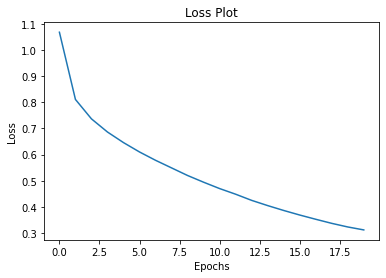

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, 64))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [ ]:
image_url = 'https://lh3.googleusercontent.com/proxy/g--qt04e3btf4TvXgLIxuzZvFiVdcQhfqRf2djydmBj9vo5pkarLpR7lLY1Gu9uAjq-kLqCuJl5s61s4oNMN92y8jp-GH-d7G21srjgRzeHF8bp91icaYu8GDOiHqCS3bg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image7'+image_extension,
                                     origin=image_url)

40960/35623 [==================================] - 0s 0us/step


Prediction Caption: a group of people that are at <unk> at camera <end>


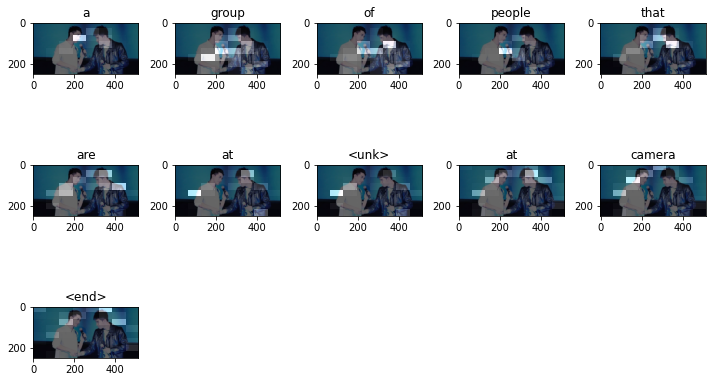

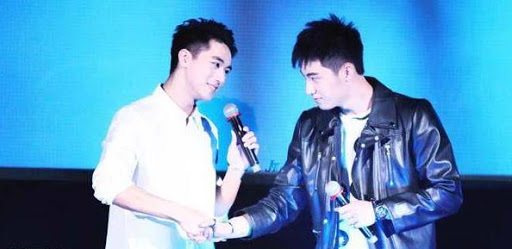

In [ ]:
result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image 
Image.open(image_path)

In [ ]:
!ls

annotations  checkpoints  sample_data  train2017


# Connect Google Storage To Save Model

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
!curl https://sdk.cloud.google.com | bash

流式输出内容被截断，只能显示最后 5000 行内容。
google-cloud-sdk/lib/surface/iot/devices/states/__init__.py
google-cloud-sdk/lib/surface/iot/devices/states/list.py
google-cloud-sdk/lib/surface/iot/devices/states/list.yaml
google-cloud-sdk/lib/surface/iot/devices/update.py
google-cloud-sdk/lib/surface/iot/registries/__init__.py
google-cloud-sdk/lib/surface/iot/registries/add_iam_policy_binding.yaml
google-cloud-sdk/lib/surface/iot/registries/create.yaml
google-cloud-sdk/lib/surface/iot/registries/credentials/__init__.py
google-cloud-sdk/lib/surface/iot/registries/credentials/clear.py
google-cloud-sdk/lib/surface/iot/registries/credentials/create.py
google-cloud-sdk/lib/surface/iot/registries/credentials/delete.py
google-cloud-sdk/lib/surface/iot/registries/credentials/describe.py
google-cloud-sdk/lib/surface/iot/registries/credentials/list.py
google-cloud-sdk/lib/surface/iot/registries/delete.py
google-cloud-sdk/lib/surface/iot/registries/delete.yaml
google-cloud-sdk/lib/surface/iot/registries/describe.py
g

In [ ]:
!gcloud init

Welcome! This command will take you through the configuration of gcloud.

Settings from your current configuration [default] are:
component_manager:
  disable_update_check: 'True'
compute:
  gce_metadata_read_timeout_sec: '0'
core:
  account: yifanliuu@gmail.com
  project: image-caption-project

Pick configuration to use:
 [1] Re-initialize this configuration [default] with new settings 
 [2] Create a new configuration
Please enter your numeric choice:  1

Your current configuration has been set to: [default]

You can skip diagnostics next time by using the following flag:
  gcloud init --skip-diagnostics

Network diagnostic detects and fixes local network connection issues.
Reachability Check passed.
Network diagnostic passed (1/1 checks passed).

Choose the account you would like to use to perform operations for 
this configuration:
 [1] yifanliuu@gmail.com
 [2] Log in with a new account
Please enter your numeric choice:  1

You are logged in as: [yifanliuu@gmail.com].

Pick cloud pr

In [ ]:
!gsutil cp -r ./checkpoints/ gs://image-caption-dataset/checkpoints/

Copying file://./checkpoints/train/checkpoint [Content-Type=application/octet-stream]...
Copying file://./checkpoints/train/ckpt-1.index [Content-Type=application/octet-stream]...
Copying file://./checkpoints/train/ckpt-4.data-00000-of-00001 [Content-Type=application/octet-stream]...
Copying file://./checkpoints/train/ckpt-3.data-00000-of-00001 [Content-Type=application/octet-stream]...
| [4 files][151.2 MiB/151.2 MiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying file://./checkpoints/train/ckpt-1.data-00000-of-00001 [Content-Type=application/octet-stream]...
Copying file://./checkpoints/train/ckpt-4.index [Content-Type=application/octet-stream]...
Copying file://./checkpoints/train/ckpt-2.data-00000-of-00001 [Content-Type=appli